# Modeling
## Estancia de investigación Maestría de Ciencia de Datos
## Aide Jazmín González Cruz

### 1. Carga de librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from siuba import *
import time
from time import gmtime, strftime

import sys
import os
from os.path import dirname
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sys.path.append(dirname('../src'))
from src.utils import utils

### 2. Carga de features y división de datos de entrenamiento y validación

In [2]:
df = pd.read_csv("../Data/hk_database_prueba.csv")
df.head(5)

,id,cx_curp,df_nacimiento,cs_sexo,first_cx,last_cx,count_cx_w,years_cx,window,x_start,...,I15,I159,I139,I131,I130,I11,I151,I158,I13,I132
0,#EHA6911199IMKERC1-1,#EHA6911199IMKERC1,19/11/1969,F,16/04/2018,06/10/2020,24.0,3,1,16/04/2018,...,0,0,0,0,0,0,0,0,0,0
1,#EHE671124ISYRCRC1-1,#EHE671124ISYRCRC1,24/11/1967,F,04/04/2017,11/12/2019,1.0,3,1,04/04/2017,...,0,0,0,0,0,0,0,0,0,0
2,AAAA2201010EDBBRC1-1,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,29.0,7,1,18/01/2005,...,0,0,0,0,0,0,0,0,0,0
3,AAAA2201010EDBBRC1-2,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,27.0,7,2,18/01/2006,...,0,0,0,0,0,0,0,0,0,0
4,AAAA2201010EDBBRC1-3,AAAA2201010EDBBRC1,16/06/1922,M,18/01/2005,10/10/2011,24.0,7,3,18/01/2007,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df['first_cx']= pd.to_datetime(df['first_cx'])
df['last_cx']= pd.to_datetime(df['last_cx'])
df['df_nacimiento']= pd.to_datetime(df['df_nacimiento'])

In [4]:
df['edad'] = np.nan
for i in range(len(df['cx_curp'])): 
    if pd.isna(df['df_nacimiento'][i]):
        df['edad'][i] = np.nan        
    else: 
        df['edad'][i] = (int(df['first_cx'][i].year-df['df_nacimiento'][i].year)+\
                        int(df['last_cx'][i].year-df['df_nacimiento'][i].year))/2

In [5]:
df["edad_range"] = np.nan
df.loc[(df['edad'] <  11), 'edad_range'] = 1#'hasta 10 años'
df.loc[(df['edad'] > 10) & (df['edad'] <= 20), 'edad_range'] = 2#'11-20'
df.loc[(df['edad'] > 20) & (df['edad'] <= 30), 'edad_range'] = 3#'21-30'
df.loc[(df['edad'] > 30) & (df['edad'] <= 40), 'edad_range'] = 4#'31-40'
df.loc[(df['edad'] > 40) & (df['edad'] <= 50), 'edad_range'] = 5#'41-50'
df.loc[(df['edad'] > 50) & (df['edad'] <= 60), 'edad_range'] = 6#'51-60'
df.loc[(df['edad'] > 60) & (df['edad'] <= 70), 'edad_range'] = 7#'61-70'
df.loc[(df['edad'] > 70) & (df['edad'] <= 80), 'edad_range'] = 8#'71-80'
df.loc[(df['edad'] > 80) & (df['edad'] <= 90), 'edad_range'] = 9#'81-90'
df.loc[(df['edad'] > 90  ), 'edad_range'] = 10#'91 y más'

In [6]:
df["imc_calculado"] = np.nan
df["imc_calculado"] = np.where(~pd.isna(df["fn_peso_median"])&~pd.isna(df["fn_talla_median"]), \
                                       (df["fn_peso_median"]/(df["fn_talla_median"]**2)), 
                                       np.nan)
df["imc_range"] = np.nan
df.loc[(df['imc_calculado'] <  18.5), 'imc_range'] = 1#'Bajo peso'
df.loc[(df['imc_calculado'] >= 18.5) & (df['imc_calculado'] < 25), 'imc_range'] = 2#'Peso normal'
df.loc[(df['imc_calculado'] >= 25  ) & (df['imc_calculado'] < 30), 'imc_range'] = 3#'Sobrepeso'
df.loc[(df['imc_calculado'] >= 30  ), 'imc_range'] = 4#'Obesidad'

In [7]:
list(df.columns)

['id',
 'cx_curp',
 'df_nacimiento',
 'cs_sexo',
 'first_cx',
 'last_cx',
 'count_cx_w',
 'years_cx',
 'window',
 'x_start',
 'x_end',
 'y_start',
 'y_end',
 'Diabetes mellitus tipo 2',
 'label',
 'anio_dx',
 'Enfermedades del sistema circulatorio',
 'Enfermedades endocrinas nutricionales y metabolicas',
 'Enfermedades del sistema osteomuscular y del tejido conjuntivo',
 'Enfermedades del sistema nervioso',
 'Factores que influyen en el estado de salud y contacto con los servicios de salud',
 'Enfermedades del sistema genitourinario',
 'Enfermedades del sistema respiratorio',
 'Enfermedades del ojo y sus anexos',
 'Trastornos mentales y del comportamiento',
 'Enfermedades del sistema digestivo',
 'Sintomas signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte',
 'Enfermedades de oido y de la apofisis mastoides',
 'Ciertas enfermedades infecciosas y parasitarias',
 'Enfermedades de la piel y del tejido subcutaneo',
 'Traumatismos envenenamientos y algunas 

In [8]:
df = df.drop(['id','cx_curp','df_nacimiento','cs_sexo','first_cx','last_cx','x_start','x_end','y_start','y_end',
         'I10X','I119','I129','I110','I150','I120','I12','I15','I159','I139','I131','I130','I11','I151',
         'I158','I13','I132','edad','imc_calculado','anio_dx','fn_peri_cefalico_mean',
 'fn_peri_cefalico_median',
 'fn_peri_cefalico_max',
 'fn_peri_cefalico_min',
 'fn_peri_cefalico_std',
 'fn_peri_toracico_mean',
 'fn_peri_toracico_median',
 'fn_peri_toracico_max',
 'fn_peri_toracico_min',
 'fn_peri_toracico_std',
 'fn_peri_abdominal_mean',
 'fn_peri_abdominal_median',
 'fn_peri_abdominal_max',
 'fn_peri_abdominal_min',
 'fn_peri_abdominal_std',
 'fn_pvc_mean',
 'fn_pvc_median',
 'fn_pvc_max',
 'fn_pvc_min',
 'fn_pvc_std',
 'fn_temp_incubadora_mean',
 'fn_temp_incubadora_median',
 'fn_temp_incubadora_max',
 'fn_temp_incubadora_min',
 'fn_temp_incubadora_std'], axis=1)

In [9]:
subset_df = df.loc[:, df.isnull().all()]
col_null = list(subset_df.columns)
col_null

[]

In [10]:
col = list(df.columns)
col

['count_cx_w',
 'years_cx',
 'window',
 'Diabetes mellitus tipo 2',
 'label',
 'Enfermedades del sistema circulatorio',
 'Enfermedades endocrinas nutricionales y metabolicas',
 'Enfermedades del sistema osteomuscular y del tejido conjuntivo',
 'Enfermedades del sistema nervioso',
 'Factores que influyen en el estado de salud y contacto con los servicios de salud',
 'Enfermedades del sistema genitourinario',
 'Enfermedades del sistema respiratorio',
 'Enfermedades del ojo y sus anexos',
 'Trastornos mentales y del comportamiento',
 'Enfermedades del sistema digestivo',
 'Sintomas signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte',
 'Enfermedades de oido y de la apofisis mastoides',
 'Ciertas enfermedades infecciosas y parasitarias',
 'Enfermedades de la piel y del tejido subcutaneo',
 'Traumatismos envenenamientos y algunas otras consecuencias de causas externas',
 'Tumores (neoplasias)',
 'Malformaciones congenitas deformidades y anomalias cromosomica

In [11]:
from sklearn.impute import SimpleImputer
# Imputation
my_imputer = SimpleImputer()
d_inp = pd.DataFrame(my_imputer.fit_transform(df))
d_inp

,0,1,2,3,4,5,6,7,8,9,...,339,340,341,342,343,344,345,346,347,348
0,24.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,5.0,3.0
1,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.675,0.030956,0.465554,29.475,0.015781,0.018209,30.0,0.000607,6.0,3.0
2,29.0,7.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,9.0,4.0
3,27.0,7.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,9.0,4.0
4,24.0,7.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,9.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,8.0,15.0,11.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.030956,0.465554,29.475,0.015781,0.018209,30.0,0.000607,6.0,3.0
3993,5.0,15.0,12.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,6.0,3.0
3994,5.0,15.0,13.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,6.0,3.0
3995,17.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,32.675,0.000000,0.000000,29.475,0.000000,0.000000,30.0,0.000000,6.0,4.0


In [12]:
d_inp.columns = col
df=d_inp.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3997 entries, 0 to 3996
Columns: 349 entries, count_cx_w to imc_range
dtypes: float64(349)
memory usage: 10.6 MB


In [13]:
spike_cols = [col for col in df.columns if '[' in col]
print(spike_cols)
spike_cols = [col for col in df.columns if ']' in col]
print(spike_cols)
spike_cols = [col for col in df.columns if '<' in col]
print(spike_cols)

['Tirotoxicosis [hipertiroidismo]', 'Deficiencia de niacina [pelagra]']
['Tirotoxicosis [hipertiroidismo]', 'Deficiencia de niacina [pelagra]']
[]


In [14]:
df.rename(columns = {'Tirotoxicosis [hipertiroidismo]':'Tirotoxicosis_hipertiroidismo', 
                     'Deficiencia de niacina [pelagra]':'Deficiencia de niacina_pelagra'}, inplace = True)

In [15]:
df.drop(['ANTIHIPERTENSIVOS_count','ANTIHIPERTENSIVOS_sum','ANTIHIPERTENSIVOS_mean',\
           'ANTIVERTIGINOSOS_sum','ANTIVERTIGINOSOS_count','ANTIVERTIGINOSOS_mean',\
           'Enfermedad cardíaca hipertensiva','Enfermedad isquémica crónica del corazón',
          'Enfermedad cardíaca hipertensiva sin insuficiencia cardíaca (congestiva)',
          'Enfermedad renal hipertensiva sin insuficiencia renal',
          'Hipertensión secundaria no especificada','Hipertensión secundaria',
          'Enfermedad cardiorrenal hipertensiva','ANTIARRITMICOS_count','ANTIARRITMICOS_sum',
          'Enfermedades del sistema circulatorio'], axis=1, inplace=True)

In [16]:
X = df.loc[:, df.columns != 'label']
print(X.shape)
Y = df[["label"]]
print(Y.shape)

(3997, 332)
(3997, 1)


In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)

### 3. Magic Loop

- Diccionario de algoritmos a aplicar

In [18]:
algorithms_dict = {'tree': 'tree_grid_search',
                   'random_forest': 'rf_grid_search',
                   'logistic': 'logistic_grid_search',
                   'xgboost': 'xgboost_grid_search'}

- Diccionario de configuraciones

In [19]:
grid_search_dict = {
                        'tree_grid_search': {
                            'max_depth': [5, 10, 15],
                            'min_samples_leaf': [3, 5, 7]
                        },
                        'rf_grid_search': {
                            'n_estimators': [30, 50, 100],
                            'max_depth': [5, 10, 15],
                            'min_samples_leaf': [3, 5, 10]
                        },
                        'logistic_grid_search':{
                            'C':np.logspace(-3,3,7),
                            'penalty':['l2']
                        },
                        'xgboost_grid_search':{
                            'max_depth': range (2, 10, 1),
                            'n_estimators': range(60, 220, 40),
                            'learning_rate': [0.1, 0.01, 0.05]
                        }
                    }

- Diccionario de estimadores

In [20]:
from xgboost import XGBClassifier

In [21]:
from sklearn.tree import DecisionTreeClassifier
estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111),
                   'random_forest': RandomForestClassifier(oob_score=True, random_state=2222),
                   'logistic': LogisticRegression(random_state=3333),
                   'xgboost': XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42)
                  } 

In [22]:
def magic_loop(algorithms, features, labels):
    best_estimators = []
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        #tscv = TimeSeriesSplit(n_splits=5)
        
        #gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=5, n_jobs=-1)
        gs = GridSearchCV(estimator, grid_params, scoring='roc_auc', cv=5, n_jobs=-1)
        
        #train
        gs.fit(features, labels)
        #best estimator
        best_estimators.append(gs)
        
        
    return best_estimators

In [23]:
#scoring_met= 'recall'
algorithms = ['tree', 'random_forest','logistic','xgboost']
models = []
models_list = []

In [24]:
X_train.columns.values.tolist()

['count_cx_w',
 'years_cx',
 'window',
 'Diabetes mellitus tipo 2',
 'Enfermedades endocrinas nutricionales y metabolicas',
 'Enfermedades del sistema osteomuscular y del tejido conjuntivo',
 'Enfermedades del sistema nervioso',
 'Factores que influyen en el estado de salud y contacto con los servicios de salud',
 'Enfermedades del sistema genitourinario',
 'Enfermedades del sistema respiratorio',
 'Enfermedades del ojo y sus anexos',
 'Trastornos mentales y del comportamiento',
 'Enfermedades del sistema digestivo',
 'Sintomas signos y hallazgos anormales clinicos y de laboratorio no clasificados en otra parte',
 'Enfermedades de oido y de la apofisis mastoides',
 'Ciertas enfermedades infecciosas y parasitarias',
 'Enfermedades de la piel y del tejido subcutaneo',
 'Traumatismos envenenamientos y algunas otras consecuencias de causas externas',
 'Tumores (neoplasias)',
 'Malformaciones congenitas deformidades y anomalias cromosomicas',
 'Enfermedades de la sangre y de los organos hem

In [25]:
start_time = time.time()
best = magic_loop(algorithms, X_train, y_train)
print("Selección de variables completada satisfactoriamente en ", time.time() - start_time, ' segundos')

Selección de variables completada satisfactoriamente en  9508.791769504547  segundos


In [26]:
best

[GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1111),
              n_jobs=-1,
              param_grid={'max_depth': [5, 10, 15],
                          'min_samples_leaf': [3, 5, 7]},
              scoring='roc_auc'),
 GridSearchCV(cv=5,
              estimator=RandomForestClassifier(oob_score=True,
                                               random_state=2222),
              n_jobs=-1,
              param_grid={'max_depth': [5, 10, 15],
                          'min_samples_leaf': [3, 5, 10],
                          'n_estimators': [30, 50, 100]},
              scoring='roc_auc'),
 GridSearchCV(cv=5, estimator=LogisticRegression(random_state=3333), n_jobs=-1,
              param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'penalty': ['l2']},
              scoring='roc_auc'),
 GridSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                    

In [27]:
len(best)

4

In [28]:
model0 = best[0].best_estimator_
model0

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=1111)

In [29]:
print(best[0].best_estimator_.n_features_)

332


In [30]:
model1 = best[1].best_estimator_
model1

RandomForestClassifier(max_depth=15, min_samples_leaf=3, oob_score=True,
                       random_state=2222)

In [31]:
print(best[1].best_estimator_.n_features_)
print(best[1].best_estimator_.oob_score_)

332
0.8877368609224169


In [32]:
model2 = best[2].best_estimator_
model2

LogisticRegression(C=0.001, random_state=3333)

In [33]:
model3 = best[3].best_estimator_
model3

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, ...)

In [34]:
utils.save_df(model0, "../output/best_model0.pkl")
utils.save_df(model1, "../output/best_model1.pkl")
utils.save_df(model2, "../output/best_model2.pkl")
utils.save_df(model3, "../output/best_model3.pkl")

### 4. Evaluando modelo

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt

In [36]:
predicted_labels0 = model0.predict(X_test)
predicted_scores0 = model0.predict_proba(X_test)

predicted_labels1 = model1.predict(X_test)
predicted_scores1 = model1.predict_proba(X_test)

predicted_labels2 = model2.predict(X_test)
predicted_scores2 = model2.predict_proba(X_test)

predicted_labels3 = model3.predict(X_test)
predicted_scores3 = model3.predict_proba(X_test)

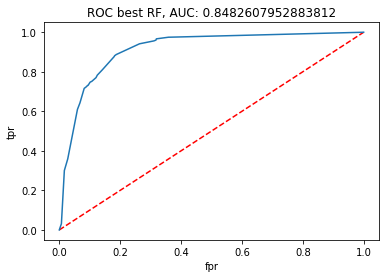

In [37]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores0[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels0)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

[[591 130]
 [ 59 420]]


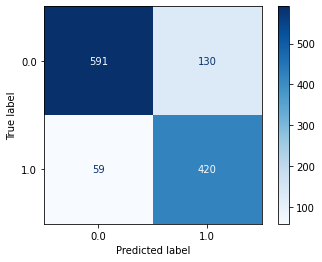

In [38]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(confusion_matrix(y_test, predicted_labels0))
plot_confusion_matrix(model0, X_test, y_test, cmap=plt.cm.Blues)  

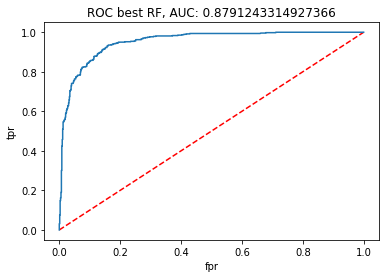

In [39]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores1[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels1)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

[[634  87]
 [ 58 421]]


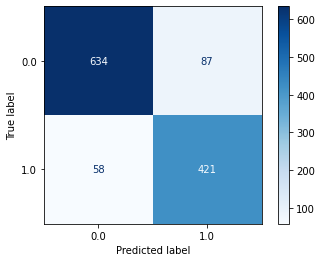

In [40]:
print(confusion_matrix(y_test, predicted_labels1))
plot_confusion_matrix(model1, X_test, y_test, cmap=plt.cm.Blues)  

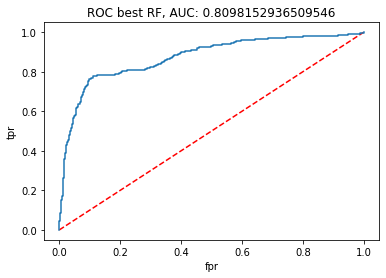

In [41]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores2[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels2)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

[[662  59]
 [143 336]]


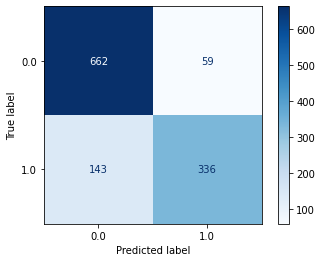

In [42]:
print(confusion_matrix(y_test, predicted_labels2))
plot_confusion_matrix(model2, X_test, y_test, cmap=plt.cm.Blues)  

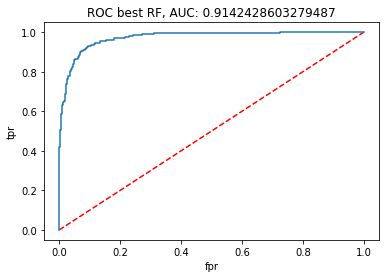

In [43]:
### Curva ROC
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores3[:, 1], pos_label=1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels3)))
plt.xlabel("fpr")
plt.ylabel("tpr")
#plt.savefig('../output/ROC_curve.png', bbox_inches='tight')
plt.show()

[[644  77]
 [ 31 448]]


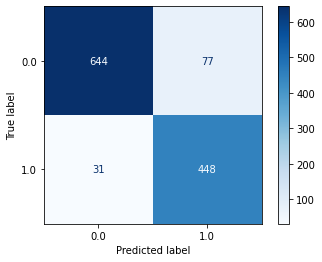

In [44]:
print(confusion_matrix(y_test, predicted_labels3))
plot_confusion_matrix(model3, X_test, y_test, cmap=plt.cm.Blues)  

In [45]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2, 'precision': precision,
                         'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)

    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']

    df = df_1.merge(df_2, on="threshold")

    return df

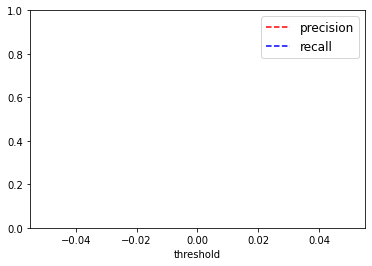

In [46]:
# Generando métricas
precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores0[:, 1], pos_label=1)
thresholds_2 = np.append(thresholds_2, 1)
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
#save_metrics(metrics_report, '../output/metricas_offline.pkl')

# Curva: Precision-recall
plt.figure()
plt.plot(metrics_report['threshold'], metrics_report['precision'], 'k--', c="red", label='precision')
plt.plot(metrics_report['threshold'], metrics_report['recall'], 'k--', c="blue", label='recall')
plt.xlabel('threshold')
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.savefig('../output/recall_precision.png', bbox_inches='tight')
#plt.show()

In [47]:
# Curva: recall-precision @k
data_junta = pd.concat([X_test, y_test], axis=1)
data_filtrada = data_junta
datos_finales_X = pd.DataFrame(data_filtrada.drop(['label'], axis=1))
y_true0 = data_filtrada.label
y_scores0 = model0.predict_proba(datos_finales_X)

# Curva: recall-precision @k
data_junta = pd.concat([X_test, y_test], axis=1)
data_filtrada = data_junta
datos_finales_X = pd.DataFrame(data_filtrada.drop(['label'], axis=1))
y_true1 = data_filtrada.label
y_scores1 = model1.predict_proba(datos_finales_X)

# Curva: recall-precision @k
data_junta = pd.concat([X_test, y_test], axis=1)
data_filtrada = data_junta
datos_finales_X = pd.DataFrame(data_filtrada.drop(['label'], axis=1))
y_true2 = data_filtrada.label
y_scores2 = model2.predict_proba(datos_finales_X)

# Curva: recall-precision @k
data_junta = pd.concat([X_test, y_test], axis=1)
data_filtrada = data_junta
datos_finales_X = pd.DataFrame(data_filtrada.drop(['label'], axis=1))
y_true3 = data_filtrada.label
y_scores3 = model3.predict_proba(datos_finales_X)

In [48]:
def param_graf(y_true, y_scores):
    k_values = np.linspace(0, 0.99, 100)
    lista = []

    for k in k_values:
        p_k = precision_at_k(y_true, pd.DataFrame(y_scores)[1], k)
        r_k = recall_at_k(y_true, pd.DataFrame(y_scores)[1], k)
        lista = lista + [[p_k, r_k, k]]

    p_r_g = pd.DataFrame(lista, columns=["p_k", "r_k", "k"])

    return p_r_g

def precision_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k * len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return precision_score(y_true, y_pred)

def recall_at_k(y_true, y_scores, k):
    threshold = np.sort(y_scores)[::-1][int(k * len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores])

    return recall_score(y_true, y_pred)

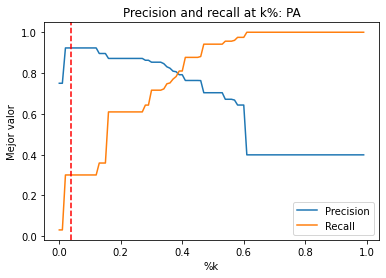

In [49]:
p_r_g = param_graf(y_true0, y_scores0)

plt.figure()
plt.plot(p_r_g["k"], p_r_g["p_k"], label="P")
plt.plot(p_r_g["k"], p_r_g["r_k"], label="R")
plt.title("Precision and recall at k%: PA")
plt.axvline(x=0.037, c='red', linestyle='--')
plt.ylabel("Mejor valor")
plt.legend(['Precision', 'Recall'])
plt.xlabel("%k")
plt.savefig('../output/recall_precision_k.png', bbox_inches='tight')
#plt.show()

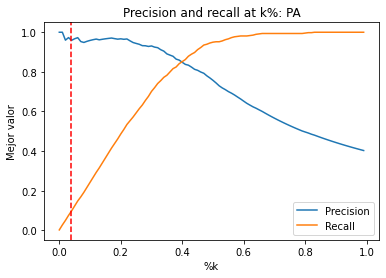

In [50]:
p_r_g = param_graf(y_true1, y_scores1)

plt.figure()
plt.plot(p_r_g["k"], p_r_g["p_k"], label="P")
plt.plot(p_r_g["k"], p_r_g["r_k"], label="R")
plt.title("Precision and recall at k%: PA")
plt.axvline(x=0.037, c='red', linestyle='--')
plt.ylabel("Mejor valor")
plt.legend(['Precision', 'Recall'])
plt.xlabel("%k")
plt.savefig('../output/recall_precision_k.png', bbox_inches='tight')
#plt.show()

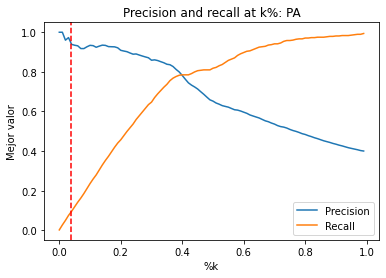

In [51]:
p_r_g = param_graf(y_true2, y_scores2)

plt.figure()
plt.plot(p_r_g["k"], p_r_g["p_k"], label="P")
plt.plot(p_r_g["k"], p_r_g["r_k"], label="R")
plt.title("Precision and recall at k%: PA")
plt.axvline(x=0.037, c='red', linestyle='--')
plt.ylabel("Mejor valor")
plt.legend(['Precision', 'Recall'])
plt.xlabel("%k")
plt.savefig('../output/recall_precision_k.png', bbox_inches='tight')
#plt.show()

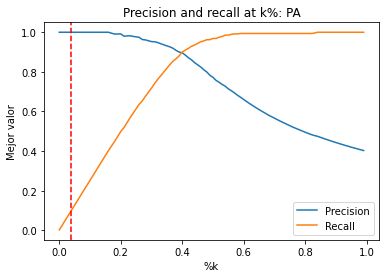

In [52]:
p_r_g = param_graf(y_true3, y_scores3)

plt.figure()
plt.plot(p_r_g["k"], p_r_g["p_k"], label="P")
plt.plot(p_r_g["k"], p_r_g["r_k"], label="R")
plt.title("Precision and recall at k%: PA")
plt.axvline(x=0.037, c='red', linestyle='--')
plt.ylabel("Mejor valor")
plt.legend(['Precision', 'Recall'])
plt.xlabel("%k")
plt.savefig('../output/recall_precision_k.png', bbox_inches='tight')
#plt.show()

### Importancia de variables

In [53]:
best_rf = best[0].best_estimator_
best_rf.feature_importances_

array([1.30036534e-02, 0.00000000e+00, 0.00000000e+00, 1.15779225e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.10222370e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [54]:
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_,
                                  'feature': X.columns.values})

In [55]:
importancias = feature_importance.sort_values(by="importance", ascending=False)

In [56]:
pd.set_option('display.max_rows', importancias.shape[0]+1)
importancias

,importance,feature
198,0.565810,fn_ta_diastolica_count
190,0.175573,fn_ta_sistolica_max
330,0.099146,edad_range
204,0.022150,in_frec_cardiaca_count
188,0.021763,fn_ta_sistolica_mean
88,0.018579,Trastornos del metabolismo de las lipoproteína...
0,0.013004,count_cx_w
3,0.011578,Diabetes mellitus tipo 2
28,0.011022,Otros trastornos de las venas
221,0.010934,in_glucosa_min


In [57]:
best_rf = best[1].best_estimator_
best_rf.feature_importances_
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_,
                                  'feature': X.columns.values})
importancias = feature_importance.sort_values(by="importance", ascending=False)
pd.set_option('display.max_rows', importancias.shape[0]+1)
importancias

,importance,feature
198,0.060949,fn_ta_diastolica_count
192,0.058069,fn_ta_sistolica_count
190,0.055773,fn_ta_sistolica_max
330,0.054152,edad_range
177,0.051086,fn_peso_count
183,0.037525,fn_talla_count
188,0.032976,fn_ta_sistolica_mean
0,0.030325,count_cx_w
216,0.028608,fn_temperatura_count
235,0.027233,ANTIULCEROSOS_Y_PROTECTORES_DE_LA_MUCOSA_GÁSTR...


In [58]:
best_rf = best[3].best_estimator_
best_rf.feature_importances_
feature_importance = pd.DataFrame({'importance': best_rf.feature_importances_,
                                  'feature': X.columns.values})
importancias = feature_importance.sort_values(by="importance", ascending=False)
pd.set_option('display.max_rows', importancias.shape[0]+1)
importancias

,importance,feature
192,0.124145,fn_ta_sistolica_count
190,0.044892,fn_ta_sistolica_max
117,0.031904,Otras deficiencias de vitaminas
330,0.027678,edad_range
93,0.017210,Otros trastornos del metabolismo de los carboh...
50,0.016116,Insuficiencia cardíaca
196,0.015910,fn_ta_diastolica_max
278,0.015304,FÁRMACOS_UTILIZADOS_EN_NEFROLOGÍA_sum
88,0.012157,Trastornos del metabolismo de las lipoproteína...
184,0.012051,fn_talla_std
